# Distilling the Knowledge in a Neural Network
## Implementation of https://arxiv.org/abs/1503.02531
---

The main idea of this work is that the probability distribution of the output of a classification model contains hidden knowledge that is not well utilized. For example, imagine a well trained model that classifies photos of food. Given a photo of a red apple, the model may classify it as an apple with a probability of 0.7. At the same time it may classify it as a tomato with a probaility of 0.1. This 0.1 contains useful information about the nature of the data. In this notebook we will initially train a very large model (ResNet) which achieves very high accuracies. Afterwards, we will train a much smaller and less accurate model with and without the guidance of this original model. The results show that training the smaller model with this approch greatly increases accuracy. As a result, this couls be a way to create more accurate compact models

In [11]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Input, Activation, Lambda, MaxPooling2D, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from shutil import copyfile
from google.colab import files, drive
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
drive.mount('/content/drive/')

## Dataset
---

The chosen [dataset](https://www.kaggle.com/alessiocorrado99/animals10?select=raw-img) consists of 28K photos of animals. There are in total 10 categories

In [3]:
files.upload()
!chmod 600 /content/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d alessiocorrado99/animals10

 97% 569M/586M [00:10<00:00, 44.4MB/s]
100% 586M/586M [00:11<00:00, 55.7MB/s]


In [0]:
!unzip animals10.zip
!rm animals10.zip

Function that randomly splits the dataset into test and train subsets

In [0]:
def split_data(path):
    
    
    train_path = os.path.join(path, 'train')
    test_path = os.path.join(path, 'test')
    if  os.path.exists(train_path) and  os.path.exists(test_path):
        print('Data already split')
    else:
        
        os.makedirs(train_path, exist_ok=True)
        os.makedirs(test_path, exist_ok = True)
        
        for folder in tqdm_notebook(os.listdir(path)):
            
            folder_path = os.path.join(path, folder)
            if os.path.isdir(folder_path) and folder != 'test' and folder != 'train':
                
                train_folder = os.path.join(train_path, folder)
                os.makedirs(train_folder, exist_ok = True)
                
                test_folder = os.path.join(test_path, folder)
                os.makedirs(test_folder, exist_ok = True)
                
                train_files, test_files = train_test_split(os.listdir(folder_path), test_size = 0.25)
                
                for file in tqdm_notebook(train_files):
                    src_file_path = os.path.join(folder_path, file)
                    dst_file_path = os.path.join(train_folder, file)
                    
                    copyfile(src_file_path, dst_file_path)
                    
                for file in tqdm_notebook(test_files):
                    src_file_path = os.path.join(folder_path, file)
                    dst_file_path = os.path.join(test_folder, file)
                    
                    copyfile(src_file_path, dst_file_path)
                    
    

This is the large model that has to achieve high accuracies. We use the pretrained weights of ResNet contaned in the keras library. We keep all the convolutional layers and add 2 fully connected layers that have to be trained.

In [3]:
def get_large_model(hidden_size, num_classes):

    resnet = ResNet50(weights = 'imagenet', include_top = False, pooling = 'max')
    for layer in resnet.layers:
        layer.trainable = False
    
    x = resnet.output
    x = Dropout(0.4) (x)
    x = Dense(hidden_size, activation = 'relu') (x)
    x = Dropout(0.4) (x)
    x = Dense(num_classes, name = 'logits') (x)
    output = Activation(keras.activations.softmax, name = 'softmax') (x)

    
    model = Model(inputs = [resnet.input], outputs = [output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


In [7]:
path = r'/content/raw-img'
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
img_shape = (224, 224)
conv_input_shape = (224, 224, 3)
batch_size = 64
hidden_size = 256
num_epochs = 10
workers = cpu_count()

In [0]:
split_data(path)

Since the dataset is too large to fit inside the memory we use an image generator that supplies batches without placing the entire dataset inside the memory.

In [8]:
datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size = img_shape,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size = img_shape,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

num_classes = len(train_generator.class_indices)
steps_per_epoch = len(train_generator.labels) // batch_size
eval_steps = len(test_generator.labels) // batch_size

Found 19631 images belonging to 10 classes.
Found 6548 images belonging to 10 classes.


In [9]:
large_model = get_large_model(hidden_size, num_classes)
large_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

conv2_block3_out (Activation)   (None, None, None, 2 0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, None, None, 1 512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, None, None, 1 0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, None, None, 1 147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, None, None, 5 2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, None, None, 5 0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, None, None, 5 0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, None, None, 2 131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, None, None, 2 0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, None, None, 1 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, None, None, 1 0           conv4_block3_out[0][0]           
          

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, None, None, 5 0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, None, None, 5 2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, None, None, 5 0           conv5_block2_2_bn[0][0]          
__________

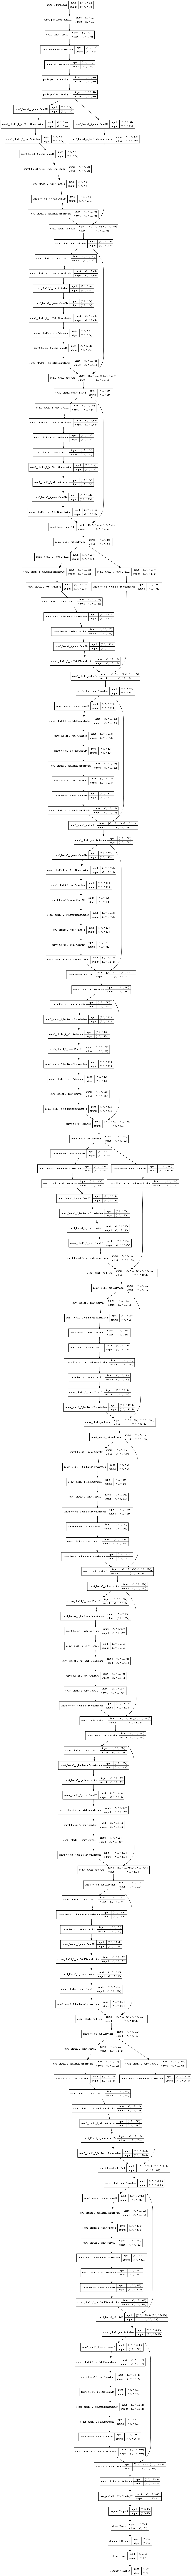

In [10]:
keras.utils.plot_model(large_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [0]:
large_model.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = steps_per_epoch,
    verbose = 1)

Epoch 1/10
306/306 [==============================] - 138s 451ms/step - loss: 1.1459 - accuracy: 0.7655
Epoch 2/10
306/306 [==============================] - 138s 452ms/step - loss: 0.4059 - accuracy: 0.8773
Epoch 3/10
306/306 [==============================] - 138s 451ms/step - loss: 0.3353 - accuracy: 0.8946
Epoch 4/10
306/306 [==============================] - 138s 451ms/step - loss: 0.2972 - accuracy: 0.9048
Epoch 5/10
306/306 [==============================] - 138s 451ms/step - loss: 0.2796 - accuracy: 0.9110
Epoch 6/10
306/306 [==============================] - 138s 451ms/step - loss: 0.2590 - accuracy: 0.9191
Epoch 7/10
306/306 [==============================] - 138s 451ms/step - loss: 0.2392 - accuracy: 0.9277
Epoch 8/10
306/306 [==============================] - 138s 451ms/step - loss: 0.2325 - accuracy: 0.9294
Epoch 9/10
306/306 [==============================] - 137s 449ms/step - loss: 0.2227 - accuracy: 0.9324
Epoch 10/10
306/306 [==============================] - 138s 451m

In [0]:
large_model.save('large_model.h5')

In [0]:
!cp large_model.h5 '/content/drive/My Drive/colab/dark_knowledge/'

The model achieves more that 0.95 accuracy on the test set

In [0]:
large_model.evaluate(test_generator, workers = workers, steps = eval_steps)

102/102 [==============================] - 46s 450ms/step - loss: 0.1373 - accuracy: 0.9629


[0.1372557282447815, 0.9629289507865906]

The following is a custom generator that supplies a batch of images as well as the output of the large model w.r.t. the said images. This is required for the distillation process. It has to be mentioned that the large model has to be modified as the output probabilities have to be 'softened' (more below).

In [0]:
def custom_generator(generator, train_path, img_shape, batch_size, workers, teacher_model):
    
    train_generator = datagen.flow_from_directory(
        train_path,
        target_size = img_shape,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    while True:
        
        data = train_generator.next()
        teacher_pred = teacher_model.predict(data[0], batch_size = batch_size, workers = workers)
        yield data[0], [data[1], teacher_pred]
        


For the distillation to be more efficient, the output probabilities of the large model have to be 'softened'. This can be achieved by using softmax with high temperature:


$$ \text {Normal softmax:   }{\sigma (z)_i} = \frac {\exp({z_i}) }  {\sum_{j=1}^{m} \exp ({z_j})}$$
<br>

$$ \text {Softmax with temperature:   }{\hat {\sigma} (z)_i} = \frac {\exp \bigl({\frac {z_i} {\tau}} \bigr)}  {\sum_{j=1}^{m} \exp \bigl ({\frac{z_j} {\tau}} \bigr )}$$

<br>

This can be easily implemented by placing a lambda layer between the logits and the softmax. The lambda layer will divide its inputs by $\tau$. Note that for $\tau = 1.0 $ the two functions are identical. If $\tau > 1.0$ then the probability distribution is softened i.e. the differences between the individual values are smaller and the model is less 'confident'.



In [0]:
def high_temp_teacher(teacher_model, temperature = 1.0):
    
    assert temperature != 0
    
    clone = keras.models.clone_model(teacher_model)
    clone.set_weights(teacher_model.get_weights()) 

        
    logits = clone.get_layer('logits').output
    logits = Lambda(lambda x : x / temperature) (logits)
    output = keras.layers.Activation(keras.activations.softmax) (logits)
    model =  Model(inputs = [clone.input], outputs = [output])
    for layer in model.layers:
        layer.trainable = False
    
    return model
    

This creates a stupid and inefficient NN that will be used for testing.
<br>
If the `use_distillation` flag is true, the model has two outputs. The first is a normal softmax (of the logits) that will be trained on the ground truth labels with crossentropy loss. The second output is a high temperature softmax (of the logits) that will be trained on the output of the large model with KL divergence loss. The overall loss function is: 
<br>
$$ Total\_loss (x) = w \cdot Crossentropy \bigl (\sigma (z), ground\_truth(x) \bigr ) + KL \bigl (\hat {\sigma} (z), LM(x) \bigr)$$

where x is the input batch, w is the weight of the ground truth loss (the paper suggests the value *0.1*), $\sigma$ is the normal softmax and $\hat {\sigma}$ is the softmax with temperature.
<br>
Otherwise, there is only one output and its loss is:
$$ Total\_loss (x) = Crossentropy \bigl (\sigma (z), ground\_truth(x) \bigr )$$

In [0]:
def get_simple_model(use_distillation, temperature, input_shape, num_classes, loss_weight = 0.1):
    
    input_ = Input(shape = input_shape)
    x = Conv2D(64,
               kernel_size = 5,
               padding = 'same',
               activation = 'relu',
               input_shape = input_shape) (input_)
    x = MaxPooling2D((3,3)) (x)
    x = Conv2D(128, 
               kernel_size = 5,
               padding = 'same',
               activation = 'relu') (x)
    x = MaxPooling2D((3,3)) (x)
    
    x = Conv2D(128, 
               kernel_size = 3,
               padding = 'same',
               activation = 'relu') (x)
    x = MaxPooling2D((2,2)) (x)
    
    x = Flatten() (x)
    x = Dense(256, activation = 'relu') (x)
    x = Dropout(0.4) (x)
    x = Dense(num_classes, name = 'logits') (x)
    output1 = Activation(keras.activations.softmax, name = 'output1') (x)
    
    if use_distillation:       
        x = Lambda(lambda x : x / temperature) (x)
        output2 = Activation(keras.activations.softmax) (x)
        model = Model(inputs = [input_], outputs = [output1, output2])
        model.compile(optimizer = 'adam',
                     metrics = ['accuracy'],
                     loss = ['categorical_crossentropy', keras.losses.kullback_leibler_divergence],
                     loss_weights = [loss_weight, 1.0])
        #keras.losses.KLDivergence
    else:
        model = Model(inputs = [input_], outputs = [output1])
        model.compile(optimizer = 'adam',
                     metrics = ['accuracy'],
                     loss = 'categorical_crossentropy')
    return model
     
    

This function is used for removing the second output of the previously defined model. This is necessary for the evaluation process.

In [0]:
def remove_distillation(orig_model):

    clone = keras.models.clone_model(orig_model)
    clone.set_weights(orig_model.get_weights())

    model = Model(inputs = [clone.input],
                  outputs = [clone.get_layer('output1').output])
    
    model.compile(optimizer = 'adam', 
                  metrics = ['accuracy'],
                  loss = 'categorical_crossentropy')

    return model

In [0]:
temperature = 5.0
gt_weight = 0.1

teacher_model = high_temp_teacher(large_model, temperature)

custom_train_generator = custom_generator(
    generator = datagen,
    train_path = train_path,
    img_shape = img_shape,
    batch_size = batch_size,
    workers = workers,
    teacher_model = teacher_model)

In [0]:
simple_model_distillation = get_simple_model(True, temperature, conv_input_shape, num_classes, gt_weight)
simple_model = get_simple_model(False, None, conv_input_shape, num_classes)

In [57]:
simple_model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 224, 224, 64)      4864      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 74, 74, 128)       204928    
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 12, 12, 128)       0  

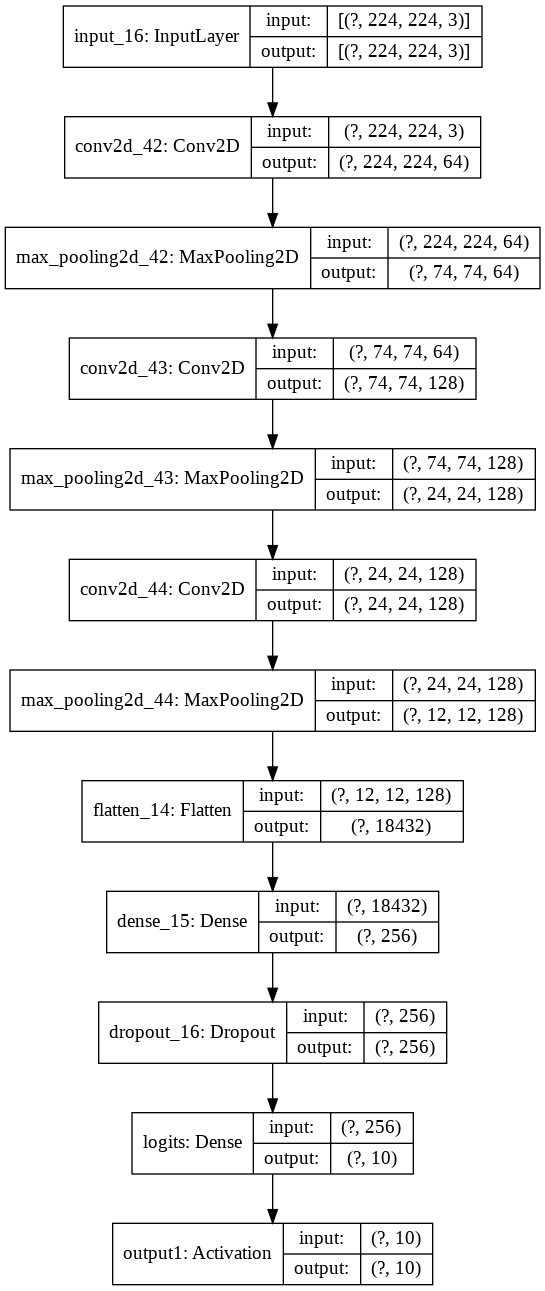

In [58]:
keras.utils.plot_model(simple_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [59]:
simple_model.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = steps_per_epoch,
    verbose = 1)

Epoch 1/10
306/306 [==============================] - 92s 301ms/step - loss: 3.8846 - accuracy: 0.2088
Epoch 2/10
306/306 [==============================] - 91s 297ms/step - loss: 2.0859 - accuracy: 0.2515
Epoch 3/10
306/306 [==============================] - 90s 295ms/step - loss: 1.9775 - accuracy: 0.2949
Epoch 4/10
306/306 [==============================] - 90s 295ms/step - loss: 1.8413 - accuracy: 0.3493
Epoch 5/10
306/306 [==============================] - 93s 303ms/step - loss: 1.7401 - accuracy: 0.3967
Epoch 6/10
306/306 [==============================] - 90s 294ms/step - loss: 1.5995 - accuracy: 0.4506
Epoch 7/10
306/306 [==============================] - 89s 290ms/step - loss: 1.4774 - accuracy: 0.4938
Epoch 8/10
306/306 [==============================] - 91s 297ms/step - loss: 1.3640 - accuracy: 0.5386
Epoch 9/10
306/306 [==============================] - 92s 301ms/step - loss: 1.2597 - accuracy: 0.5675
Epoch 10/10
306/306 [==============================] - 90s 293ms/step - l

In [0]:
simple_model.save('simple_model.h5')
!cp simple_model.h5 '/content/drive/My Drive/colab/dark_knowledge/'

Without distillation, the simple network can only reach about 0.5 accuracy on the testset. Increasing the number of training epochs does not help as the model seriously overfits.

In [43]:
simple_model.evaluate(test_generator, workers = workers, steps = eval_steps)

102/102 [==============================] - 20s 199ms/step - loss: 2.7705 - accuracy: 0.4989


[2.7705330848693848, 0.49892041087150574]

In [47]:
simple_model_distillation.fit(
    custom_train_generator,
    epochs = num_epochs,
    steps_per_epoch = steps_per_epoch,
    verbose = 1)

Found 19631 images belonging to 10 classes.
Epoch 1/10
306/306 [==============================] - 212s 692ms/step - loss: 1.7638 - output1_loss: 4.5000 - activation_19_loss: 1.3138 - output1_accuracy: 0.2801 - activation_19_accuracy: 0.2782
Epoch 2/10
306/306 [==============================] - 212s 694ms/step - loss: 1.2109 - output1_loss: 2.2531 - activation_19_loss: 0.9856 - output1_accuracy: 0.3966 - activation_19_accuracy: 0.3963
Epoch 3/10
306/306 [==============================] - 213s 697ms/step - loss: 1.0329 - output1_loss: 2.0330 - activation_19_loss: 0.8296 - output1_accuracy: 0.4821 - activation_19_accuracy: 0.4826
Epoch 4/10
306/306 [==============================] - 211s 691ms/step - loss: 0.9020 - output1_loss: 1.8086 - activation_19_loss: 0.7212 - output1_accuracy: 0.5391 - activation_19_accuracy: 0.5392
Epoch 5/10
306/306 [==============================] - 213s 695ms/step - loss: 0.7892 - output1_loss: 1.5683 - activation_19_loss: 0.6324 - output1_accuracy: 0.5971 - ac

In [0]:
simple_model_distillation.save('simple_model_distillation.h5')

In [0]:
!cp simple_model_distillation.h5 '/content/drive/My Drive/colab/dark_knowledge/'

In [0]:
final_model = remove_distillation(simple_model_distillation)

Using distillation, the simple model achieves 0.6 accuracy on the testset which is 0.1 better than the previous attempt

In [55]:
final_model.evaluate(test_generator, workers = workers, steps = eval_steps)

102/102 [==============================] - 20s 194ms/step - loss: 2.0619 - accuracy: 0.6055


[2.0618932247161865, 0.6054904460906982]

The results prove that training simple neural networks with distillation significantly increases accuracy. The results could have been improved even more by hyperparameter tuning of the temperature $\tau$ and the ground truth loss weight *w*.